This notebook is based on/devloped on top of: https://github.com/yashdeep01/Time-Series-Forecasting/blob/main/.ipynb_checkpoints/time-series-Copy1-checkpoint.ipynb

# Florida SST prediction/forcast model

## environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install xarray
!pip install pmdarima

In [ ]:
import xarray as xr
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import math
from sklearn.metrics import mean_squared_error

## data processing

In [ ]:
import copernicusmarine as cm

cm.subset(
  dataset_id="cmems_obs-sst_glo_phy_nrt_l4_P1D-m",
  dataset_version="202303",
  variables=["analysed_sst", "analysis_error", "mask", "sea_ice_fraction"],
  minimum_longitude=-88,
  maximum_longitude=-79,
  minimum_latitude=24,
  maximum_latitude=31,
  start_datetime="2021-01-01T00:00:00",
  end_datetime="2024-02-04T00:00:00",
)

# rename file to 'copernicus_florida_sst.nc'

In [ ]:
filename2 = 'copernicus_florida_sst.nc'
ds2 = xr.open_dataset('copernicus_florida_sst.nc')
df2 = ds2.to_dataframe()
df2.to_csv(filename2[:-3] + '.csv')
print(filename2 + ' has been processed to .csv')

In [ ]:
# limit scope to N24.55 W81.75

df3 = pd.read_csv("copernicus_florida_sst.csv")
filtered_df3 = df3[(df3['latitude'] == 24.55) & (df3['longitude'] == -81.75)]
print(filtered_df3)
print(filtered_df3.isna().sum())

               time  latitude  longitude  analysed_sst  analysis_error  mask  \
512      2021-01-01     24.55     -81.75        295.99            0.93   1.0   
6812     2021-01-02     24.55     -81.75        296.23            0.93   1.0   
13112    2021-01-03     24.55     -81.75        296.53            0.93   1.0   
19412    2021-01-04     24.55     -81.75        296.72            0.93   1.0   
25712    2021-01-05     24.55     -81.75        296.55            0.93   1.0   
...             ...       ...        ...           ...             ...   ...   
7088012  2024-01-31     24.55     -81.75        295.66            0.72   1.0   
7094312  2024-02-01     24.55     -81.75        295.55            0.75   1.0   
7100612  2024-02-02     24.55     -81.75        295.58            0.71   1.0   
7106912  2024-02-03     24.55     -81.75        295.22            0.74   1.0   
7113212  2024-02-04     24.55     -81.75        295.18            0.74   1.0   

         sea_ice_fraction  
512        

In [ ]:
filtered_df3.dtypes

time                 object
latitude            float64
longitude           float64
analysed_sst        float64
analysis_error      float64
mask                float64
sea_ice_fraction    float64
dtype: object

In [ ]:
# Converting `time` field to `datetime`
filtered_df3['time'] = pd.to_datetime(filtered_df3['time'])
print(filtered_df3.dtypes)
print(filtered_df3['time'].iloc[0])
print(filtered_df3)

print(filtered_df3['latitude'].nunique(dropna=True) == filtered_df3['longitude'].nunique(dropna=True))
print(filtered_df3['latitude'].unique(), filtered_df3['longitude'].unique())

print("Columns: {}".format(filtered_df3.columns.tolist()))
df4 = filtered_df3[['time', 'analysed_sst']]
print(df4)

In [ ]:
# get unique values for time column

# df4.value_counts()
df4['time'].value_counts() # 1130
# print(df4['analysed_sst'].value_counts())

In [ ]:
# Setting index for time-series data
df5 = df4
print(df4)
df5 = df5.set_index('time')
print(df5)

In [ ]:
# convert K to C - do not run multiple times
df5['analysed_sst'] = df5['analysed_sst'].apply(lambda x: x - 273.15)
print(df5)

            analysed_sst
time                    
2021-01-01         22.84
2021-01-02         23.08
2021-01-03         23.38
2021-01-04         23.57
2021-01-05         23.40
...                  ...
2024-01-31         22.51
2024-02-01         22.40
2024-02-02         22.43
2024-02-03         22.07
2024-02-04         22.03

[1130 rows x 1 columns]


In [ ]:
# weekly series
series = df5.resample('W').mean()
series

,analysed_sst
time,
2021-01-03,23.100000
2021-01-10,22.940000
2021-01-17,22.604286
2021-01-24,22.222857
2021-01-31,22.620000
...,...
2024-01-07,22.567143
2024-01-14,23.030000
2024-01-21,23.508571


## plotting

In [ ]:
period_num = 52

### weekly and daily visualization

<Axes: xlabel='time'>

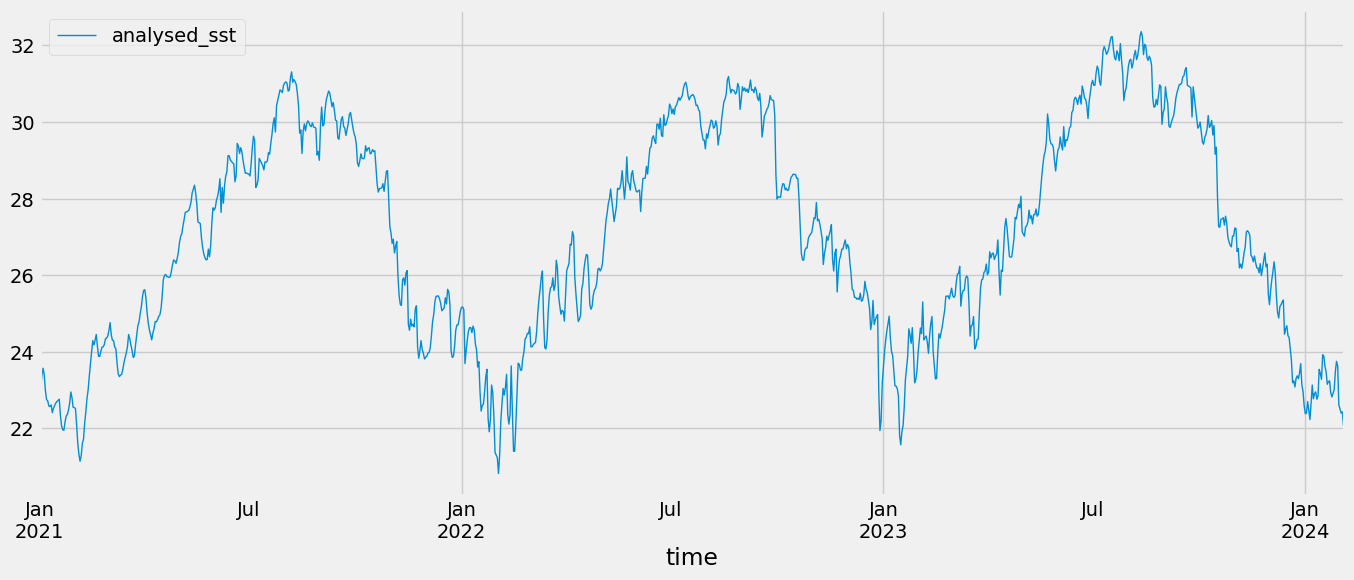

In [ ]:
df5.plot(grid=True)

<Axes: xlabel='time'>

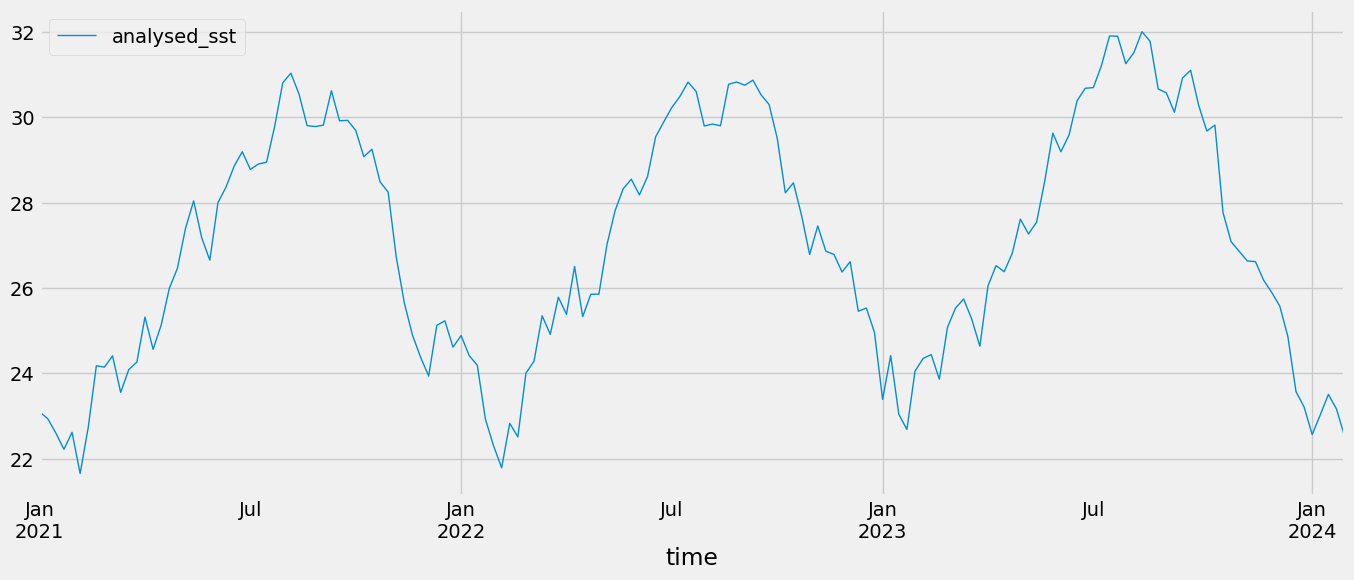

In [ ]:
series.plot(grid=True)

### decompostion

In [ ]:
decomposition = seasonal_decompose(series, model='additive',
                                   period=period_num)

<Axes: xlabel='time'>

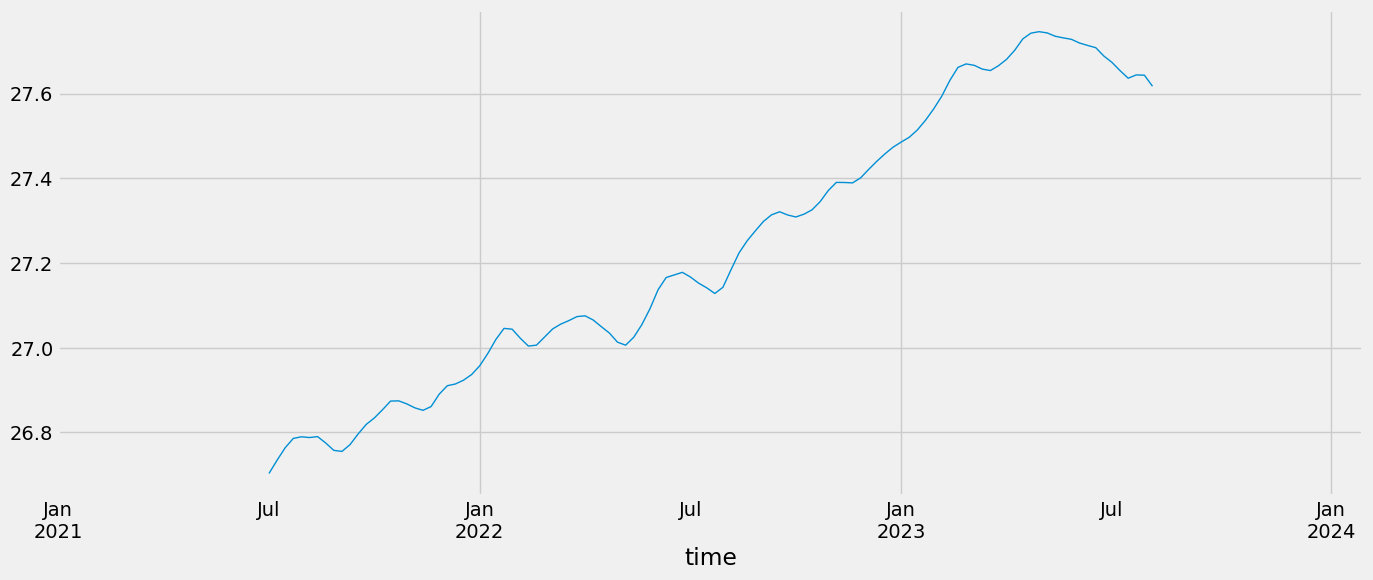

In [ ]:
# Trend
decomposition.trend.plot()

<Axes: xlabel='time'>

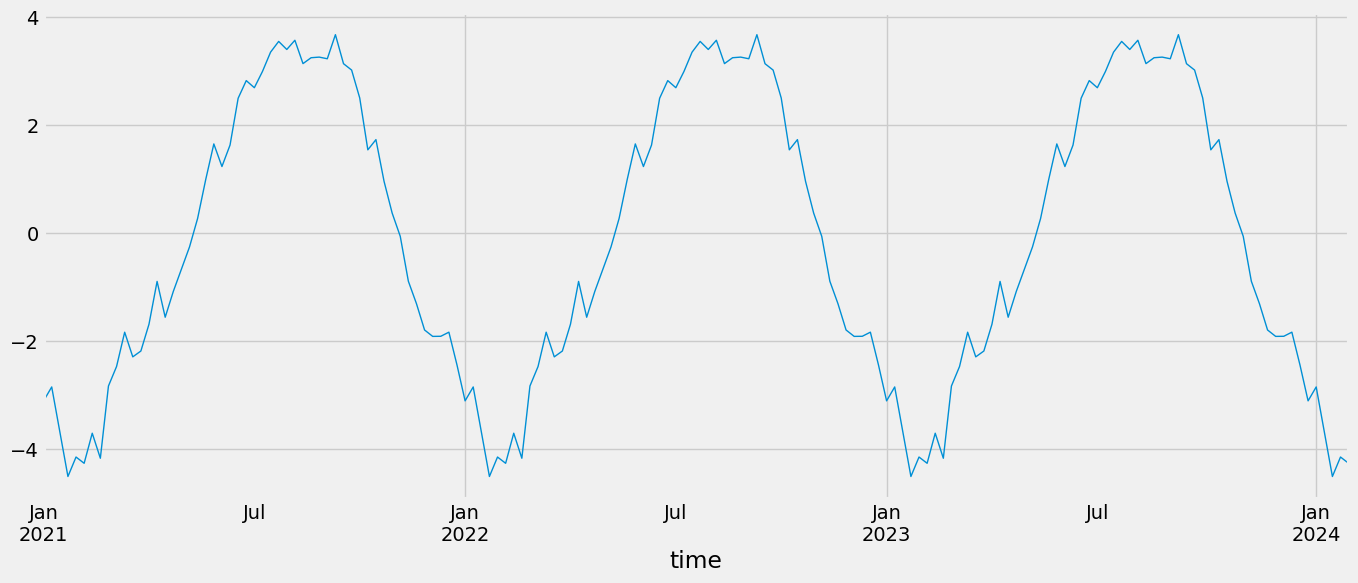

In [ ]:
# Seasonal
decomposition.seasonal.plot(figsize=(15,6))

<Axes: xlabel='time'>

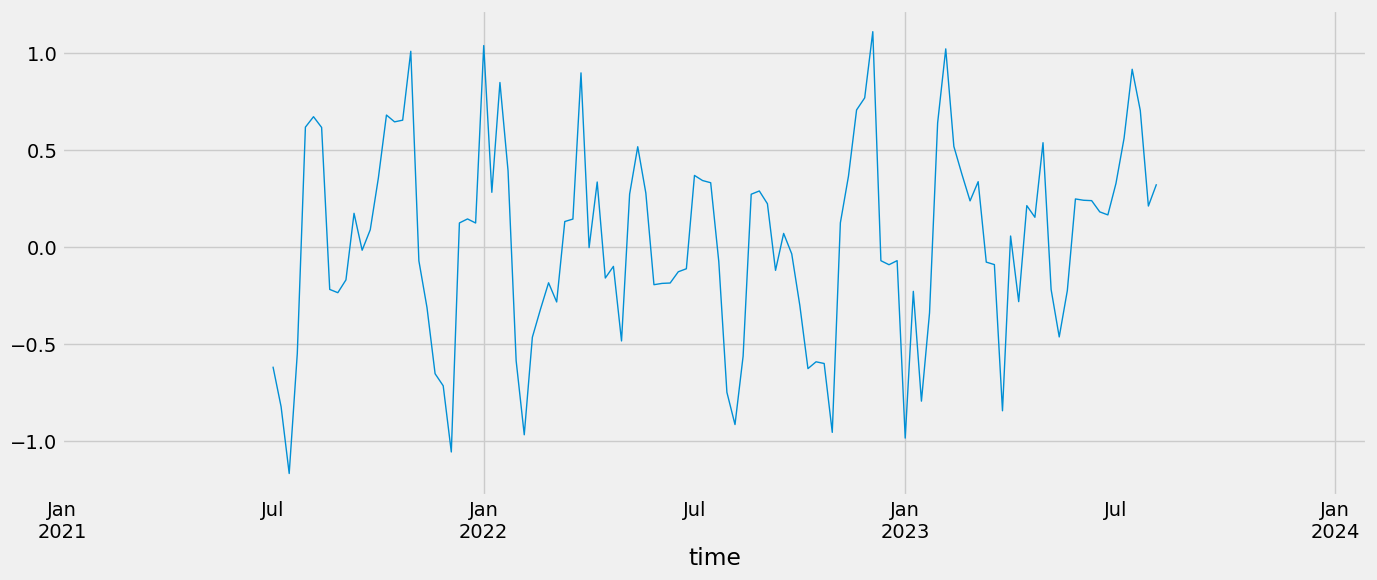

In [ ]:
# Residual
decomposition.resid.plot(figsize=(15,6))

<Axes: xlabel='time'>

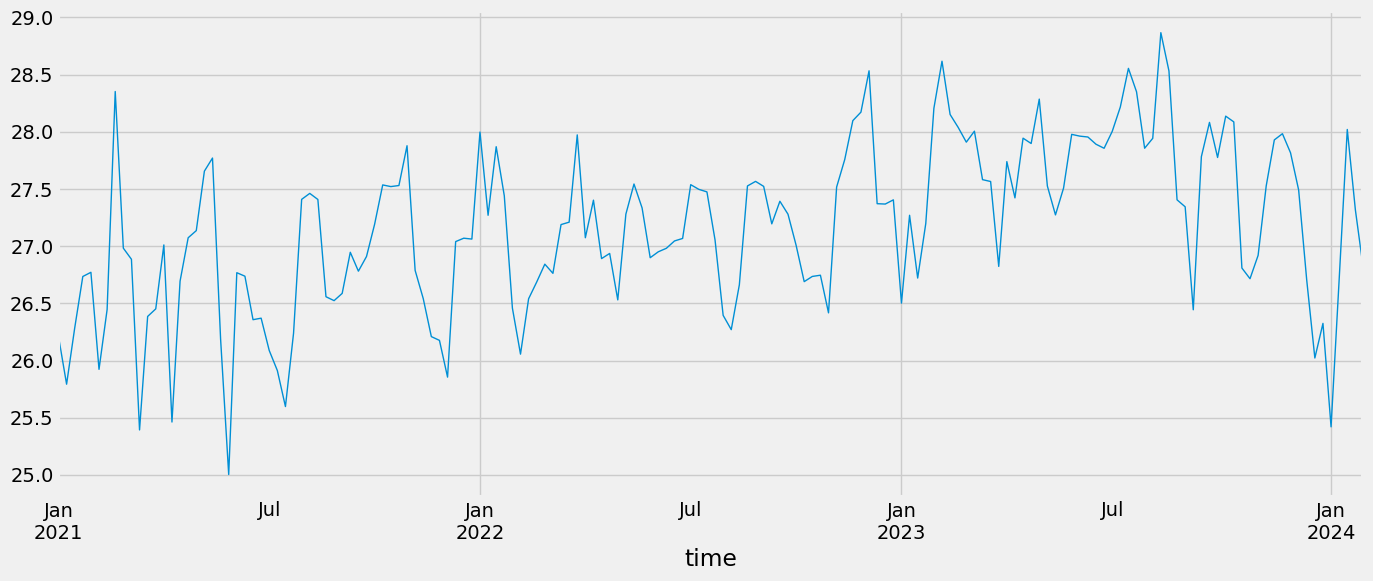

In [ ]:
# Plotting time-series without seasonal component

# Simple subtraction works because of additive model
seasonal_adj = decomposition.observed - decomposition.seasonal
seasonal_adj.plot(figsize=(15,6))

## predictions

### Holt-Winters exponential smoothing

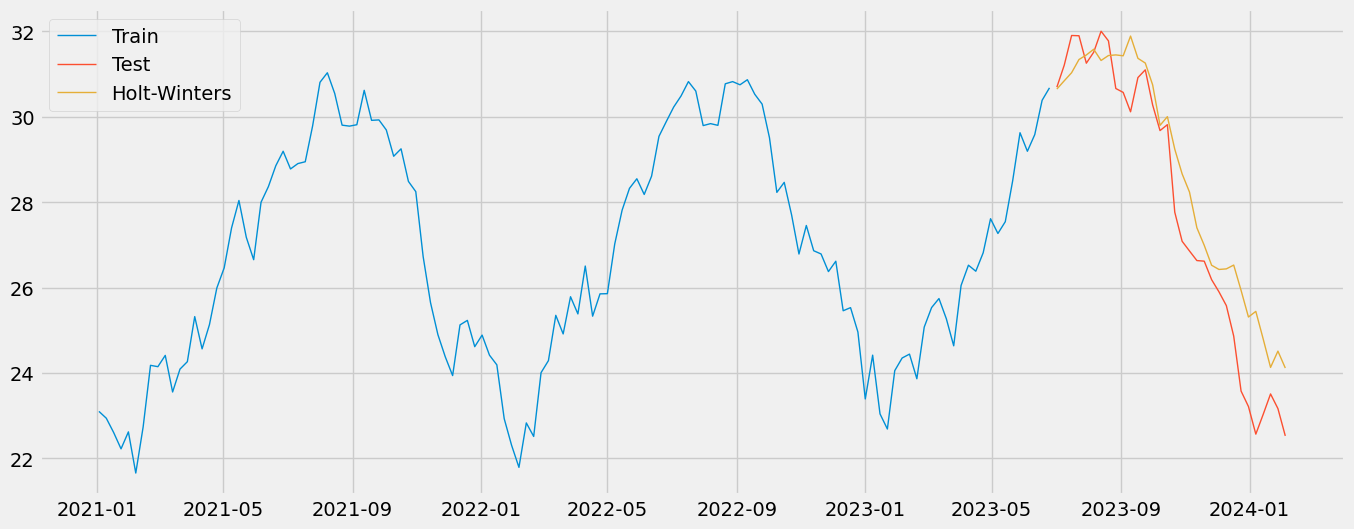

In [ ]:
""""
With the model being additive, and seasonality present,
we use Holt-Winters exponential smoothing
"""

# Train-test split (arbitrary)
train, test = series.iloc[:130, 0], series.iloc[130:, 0]

# Create model
model = ExponentialSmoothing(train, freq='W', trend='add', seasonal='add',
                             seasonal_periods=period_num)
# Fit model
model_fit = model.fit()
# Make prediction
pred = model_fit.predict(start=test.index[0], end=test.index[-1])

# Plot the line graphs
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [ ]:
rms = math.sqrt(mean_squared_error(test, pred))
rms # Root-mean-square deviation, lower is better

1.1740028759626875

In [ ]:
print(f"P-value: {adfuller(series, autolag='AIC')[1]}")

P-value: 2.309501643778366e-08


### ARIMA

In [ ]:
# Time series is stationary

stepwise_model = auto_arima(series, stepwise=True, m=52, trace=True, stationary=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=19.48 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=797.136, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=350.066, Time=4.25 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1531.626, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=349.741, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=350.220, Time=1.17 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=350.128, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=350.523, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=633.796, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=353.526, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[52] intercept
Total fit time: 42.092 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -171.871
Date:                Thu, 04 Apr 2024   AIC                            349.741
Time:                        20:32:18   BIC                            359.004
Sample:                    01-03-2021   HQIC                           353.502
                         - 02-04-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6649      0.550      1.209      0.227      -0.413       1.743
ar.L1          0.9741      0.021     46.868      0.000       0.933       1.015
sigma2         0.4798      0.063      7.626      0.000       0.356       0.603
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.21   Prob(JB):                         0.43
Heteroskedasticity (H):               0.99   Skew:                            -0.10
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
params = stepwise_model.get_params()
params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 52),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction = model_fit.predict(start=start, end=end)
# prediction.index = series.index[start:end+1] #? meaning no need to set index?

<Axes: xlabel='time'>

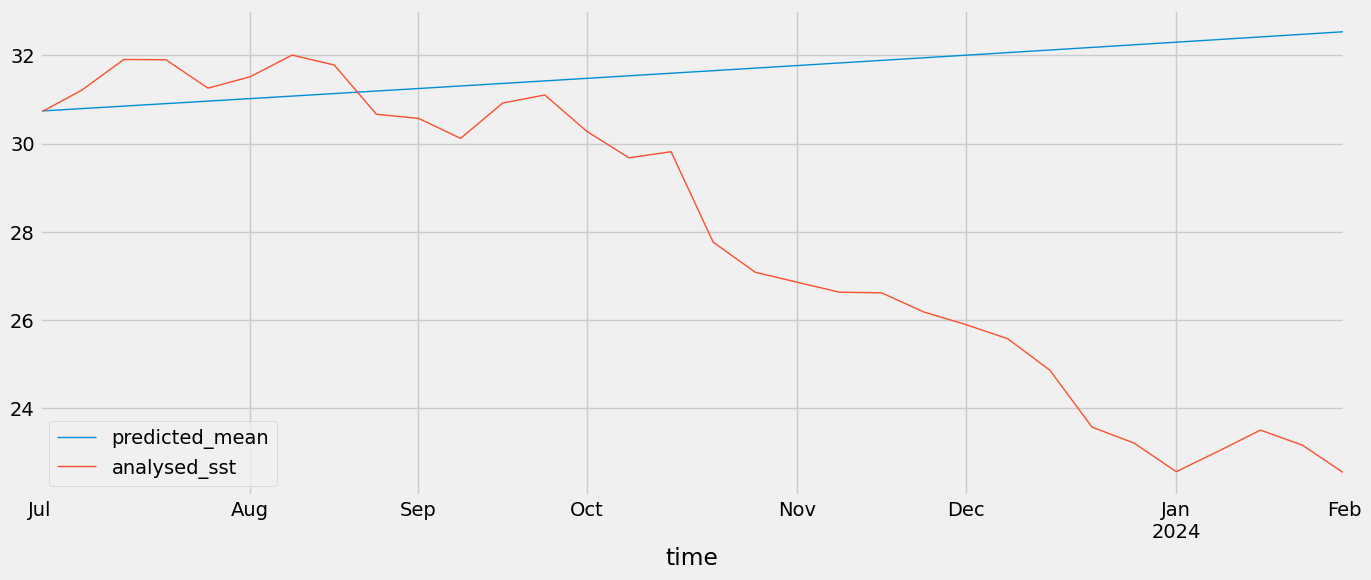

In [ ]:
# New plot
prediction.plot(legend=True)
test.plot(legend=True)

In [ ]:
rmse = math.sqrt(mean_squared_error(test, prediction))
print(f"RMSE: {rmse}")
print(f"Series mean: {series['analysed_sst'].mean()}")

RMSE: 5.297197802849755
Series mean: 27.02590828924165


In [ ]:
input_weeks = 50

forecast_model = SARIMAX(series, order=order,
                  seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=False)

forecast_fit = forecast_model.fit()

forecast = forecast_fit.predict(start=len(series), end=len(series)+input_weeks)
forecast.index = pd.date_range(series.index[-1], periods= input_weeks+1, freq='W')

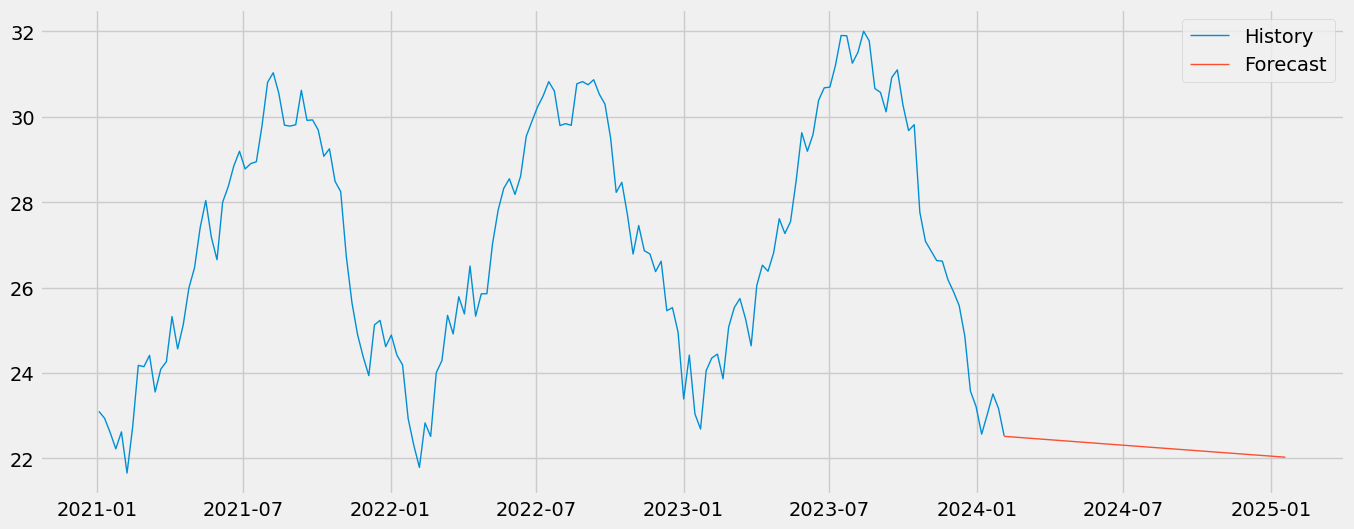

In [ ]:
plt.plot(series.index, series, label='History')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(loc='best')